<a href="https://colab.research.google.com/github/Lavyadev/EXXA/blob/main/General_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Final Dataset Shape: (150, 600, 600, 1)
Final Dataset Shape: (150, 600, 600, 1)


<Figure size 1500x1000 with 0 Axes>

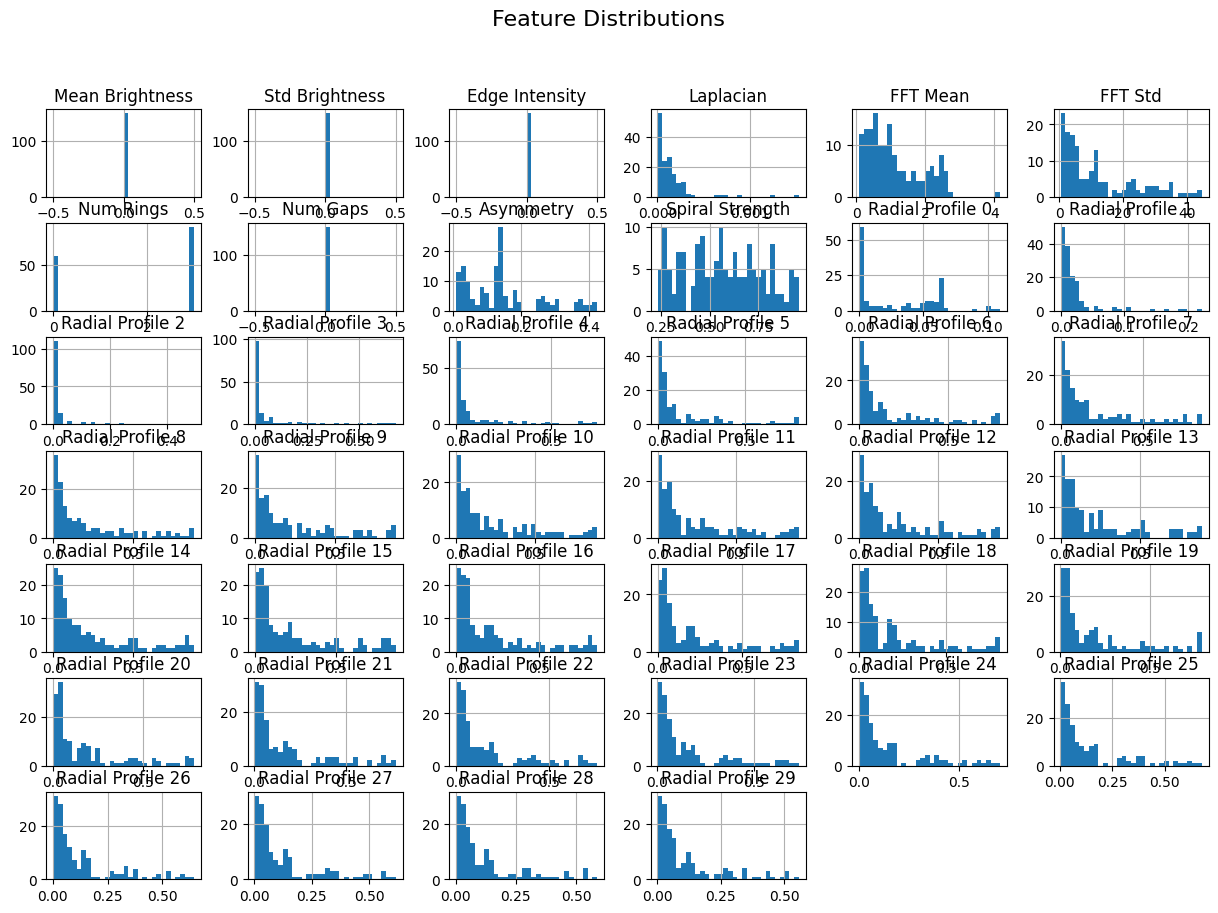

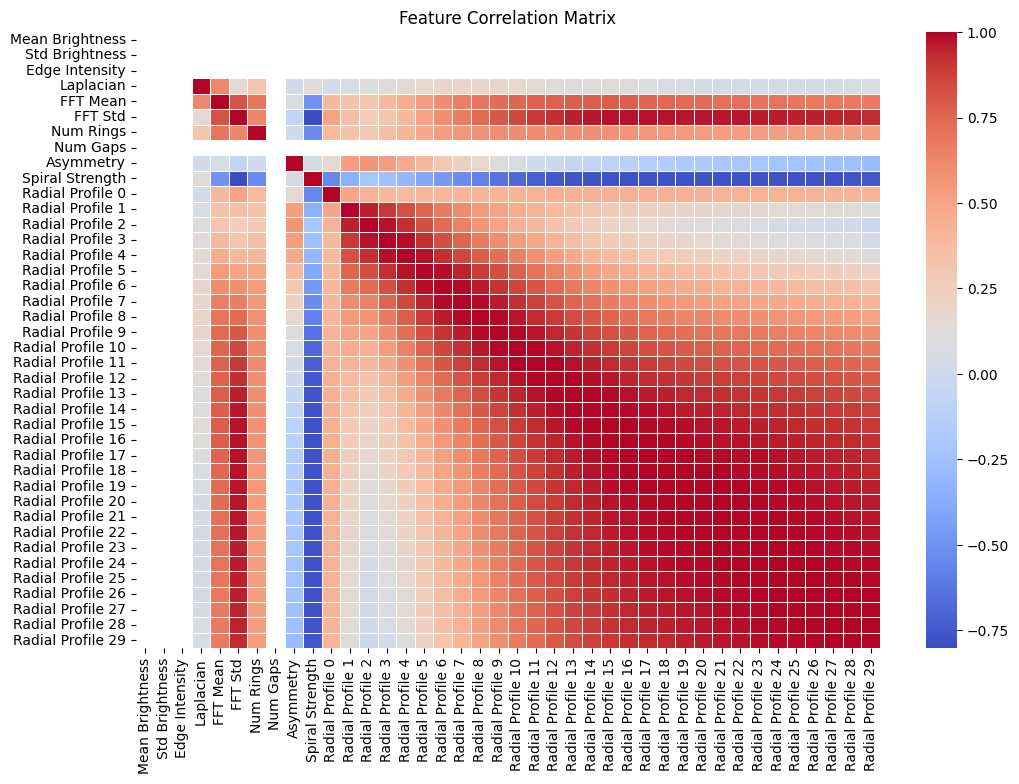

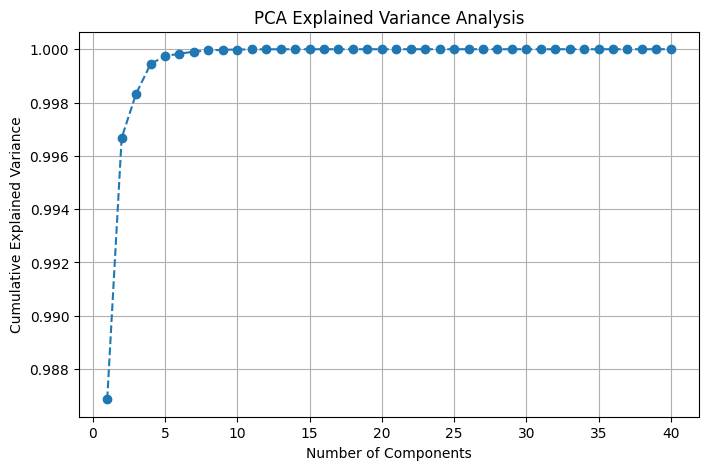

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


PCA Silhouette Score: 0.6748
UMAP Silhouette Score: 0.6822
Using UMAP features for clustering


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Optimal Clusters: 3, Silhouette Score: 0.5260, CH Score: 89.9787
DBSCAN found 4 clusters
KMeans Silhouette Score: 0.4813
DBSCAN Silhouette Score: 0.7078


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


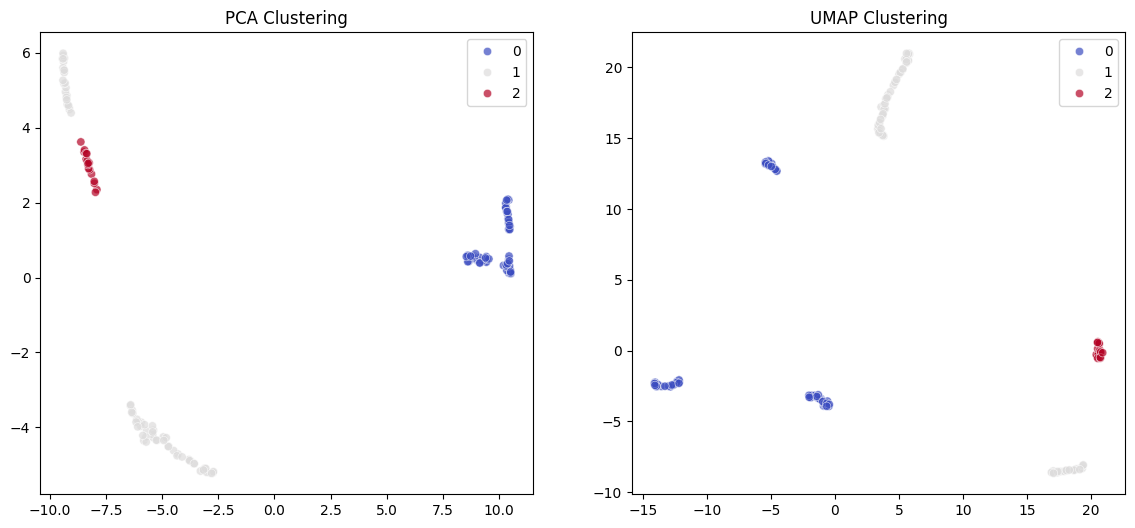

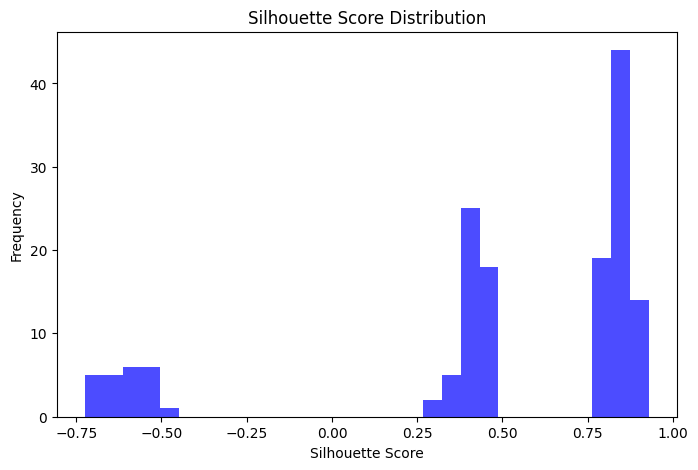

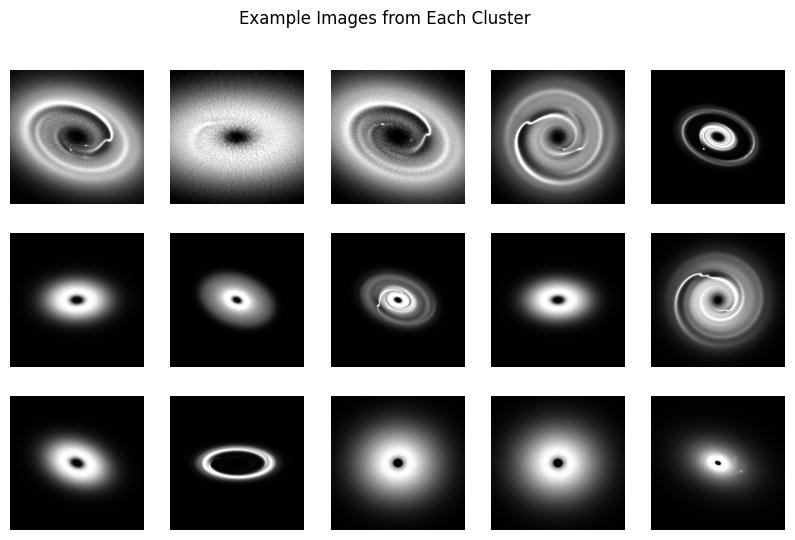


--- Cluster 0 ---


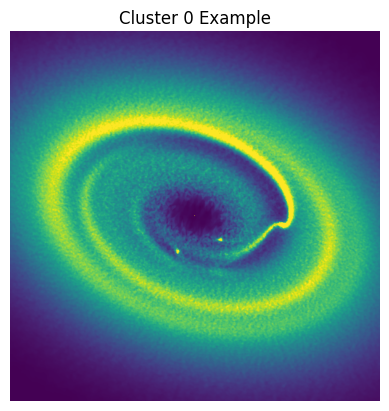

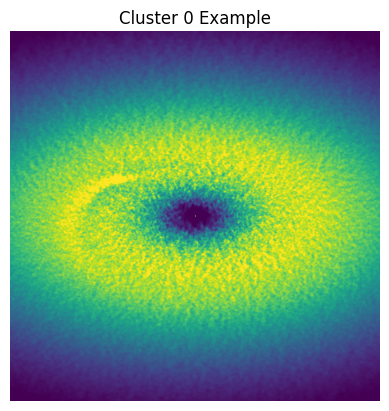

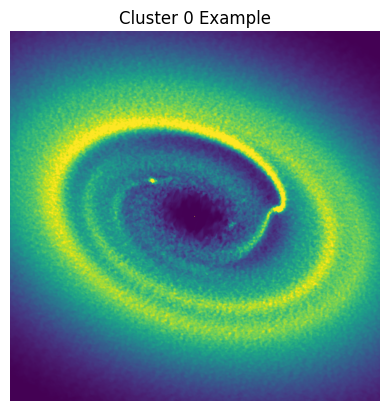

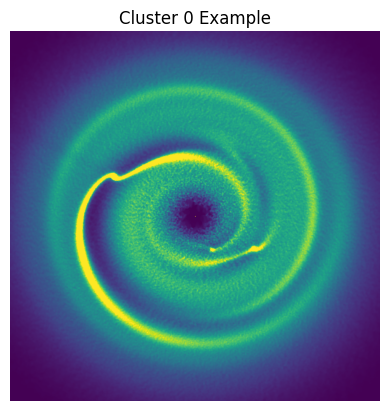

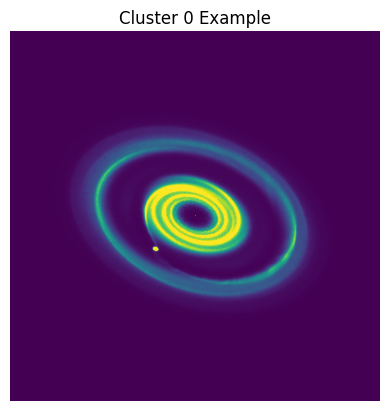


--- Cluster 1 ---


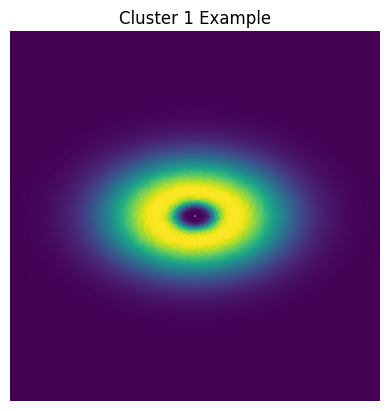

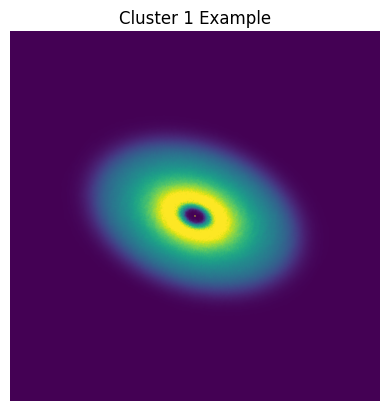

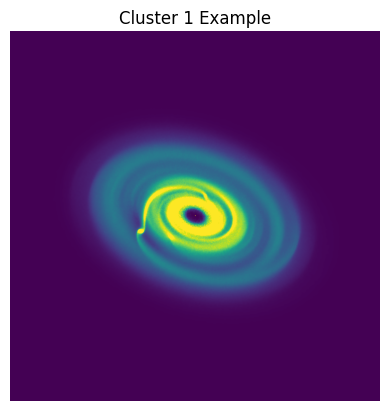

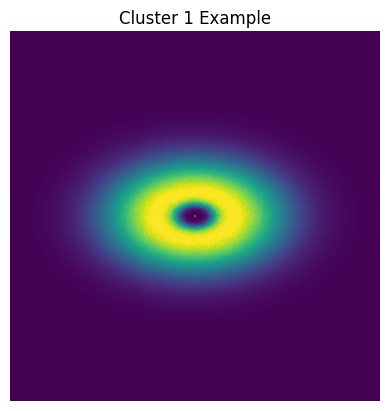

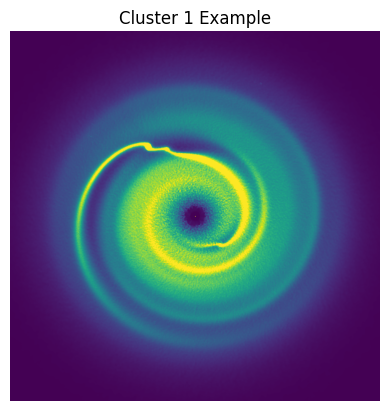


--- Cluster 2 ---


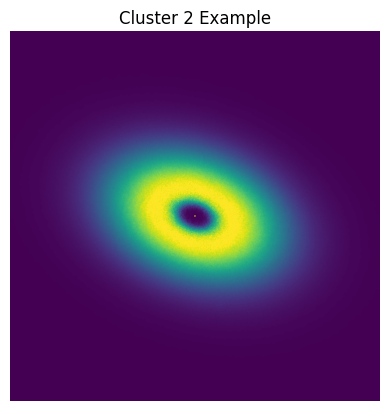

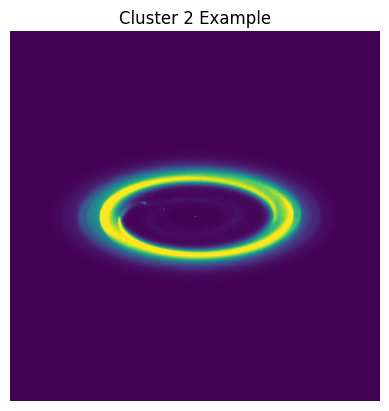

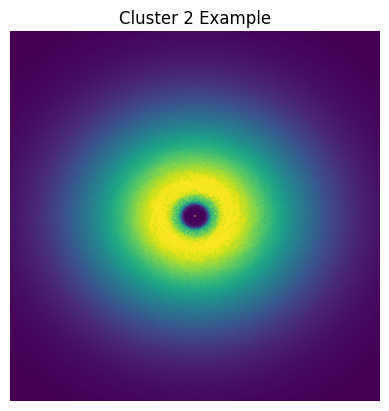

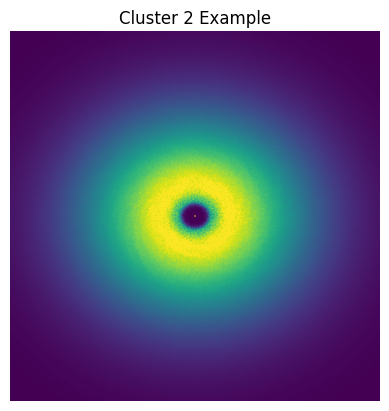

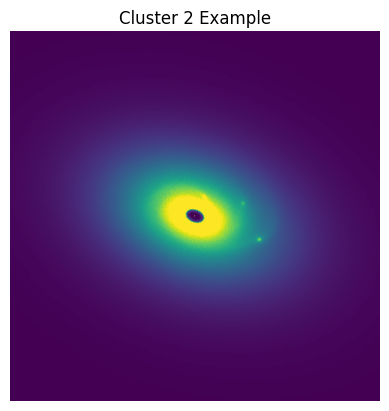

         Mean Brightness  Std Brightness  Edge Intensity  Laplacian  FFT Mean  \
Cluster                                                                         
0                    0.0             0.0             0.0   0.000064  0.431241   
1                    0.0             0.0             0.0   0.000179  1.492083   
2                    0.0             0.0             0.0   0.000240  1.861988   

           FFT Std  Num Rings  Num Gaps  Asymmetry  Spiral Strength  ...  \
Cluster                                                              ...   
0         2.576807   0.100000       0.0   0.144615         0.710657  ...   
1        17.016348   2.958904       0.0   0.135797         0.483404  ...   
2        21.948636   3.000000       0.0   0.197952         0.411662  ...   

         Radial Profile 20  Radial Profile 21  Radial Profile 22  \
Cluster                                                            
0                 0.035091           0.033413           0.032018   
1        

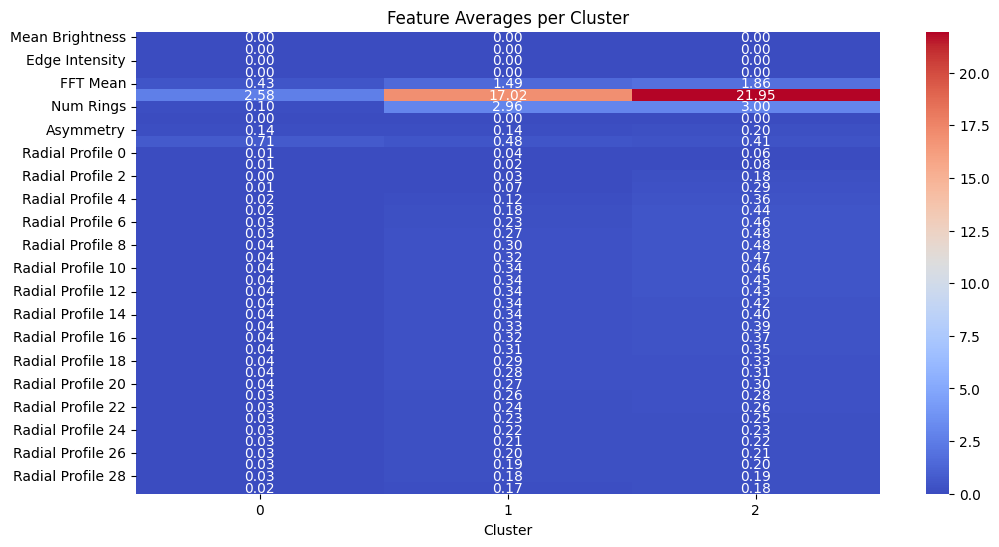


=== Computing SHAP values ===
Final SHAP values shape: (150, 15, 3)
SHAP importance shape: (15,)


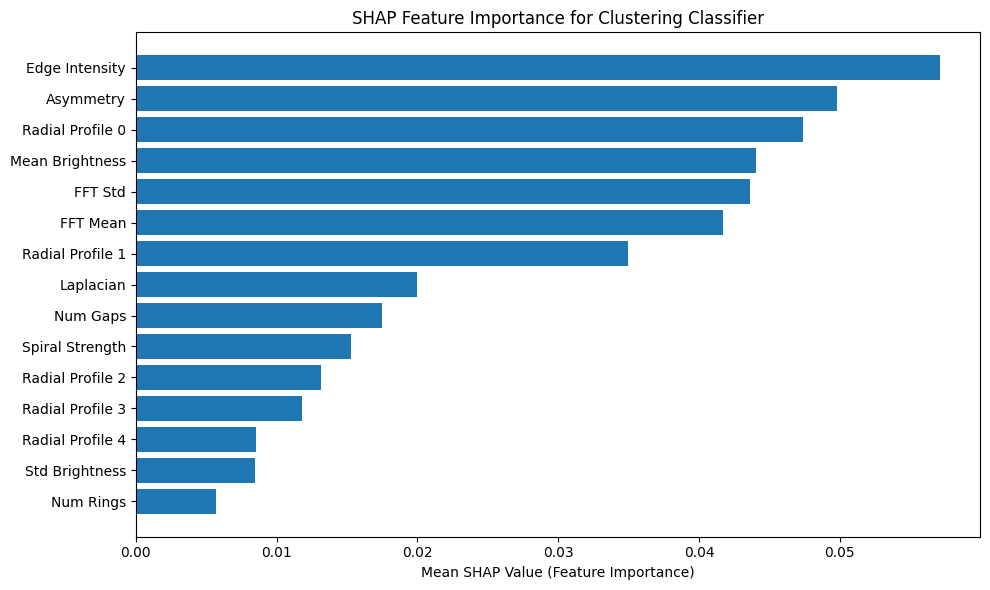

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from astropy.io import fits
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples
import umap
import cv2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model, load_model
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
from sklearn.manifold import TSNE
import pickle
from sklearn.decomposition import PCA
import seaborn as sns
import albumentations as A
import pandas as pd
from sklearn.preprocessing import StandardScaler
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split

def normalize_for_display(img, clip_percentile=(1, 99)):

    flat = img.flatten()
    flat = flat[np.isfinite(flat)]
    if flat.size == 0:
        return np.zeros_like(img)


    vmin, vmax = np.percentile(flat, clip_percentile)
    img_clipped = np.clip(img, vmin, vmax)


    return (img_clipped - vmin) / (vmax - vmin + 1e-8)




augment = A.Compose([
    A.Rotate(limit=360, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

def augment_image(image):
    return augment(image=image)['image']

def load_data(data_folder, augment_data=False):
    image_list = []
    for filename in os.listdir(data_folder):
        if filename.endswith(".fits"):
            file_path = os.path.join(data_folder, filename)
            fits_data = fits.open(file_path)
            image_data = np.squeeze(fits_data[0].data)[0]
            image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
            if augment_data:
                image_data = augment_image(image_data)
            image_list.append(image_data)
            fits_data.close()
    image_array = np.expand_dims(np.array(image_list), axis=-1)
    print("Final Dataset Shape:", image_array.shape)
    return image_array

def to_polar(image, center=None):
    if center is None:
        center = (image.shape[1] // 2, image.shape[0] // 2)
    max_radius = np.sqrt(center[0] ** 2 + center[1] ** 2)
    polar_img = cv2.linearPolar(image, center, max_radius, cv2.WARP_FILL_OUTLIERS)
    return polar_img

def detect_rings(image):
    edges = canny(image, sigma=1.5)
    hough_radii = np.arange(5, 50, 2)
    hough_res = hough_circle(edges, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=3)
    return len(radii)

def detect_gaps(radial_profile, min_gap_depth=0.2, min_gap_width=3):
    smooth_profile = cv2.GaussianBlur(radial_profile.reshape(-1, 1), (5, 5), 0).flatten()
    derivative = np.gradient(smooth_profile)
    gap_indices = np.where(derivative < -min_gap_depth)[0]
    gap_clusters = np.split(gap_indices, np.where(np.diff(gap_indices) > min_gap_width)[0] + 1)
    gap_clusters = [g for g in gap_clusters if len(g) > 0]
    num_gaps = len(gap_clusters)
    return num_gaps

def compute_asymmetry(image, num_angles=8):
    polar_image = to_polar(image)
    sector_size = polar_image.shape[0] // num_angles
    sector_means = [np.mean(polar_image[i*sector_size:(i+1)*sector_size]) for i in range(num_angles)]
    asymmetry_score = np.std(sector_means) / (np.mean(sector_means) + 1e-8)
    return asymmetry_score

def detect_spirals(image, threshold=0.3):
    fft = np.fft.fft2(image)
    fft_shift = np.fft.fftshift(fft)
    magnitude = np.abs(fft_shift)
    y, x = np.indices(image.shape)
    center = (image.shape[0]//2, image.shape[1]//2)
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    mask = r < 10
    magnitude[mask] = 0
    spiral_strength = np.sum(magnitude) / np.sum(np.abs(fft))
    return spiral_strength

def extract_morphological_features(image):
    if len(image.shape) != 2:
        if len(image.shape) == 3 and image.shape[-1] == 1:
            image = image.squeeze()
        else:
            raise ValueError(f"Unexpected image shape: {image.shape}")
    small_image = cv2.resize(image, (150, 150), interpolation=cv2.INTER_AREA)
    edges = cv2.Canny((small_image * 255).astype(np.uint8), 50, 150)
    laplacian = cv2.Laplacian(small_image.astype(np.float64), cv2.CV_64F).var()
    mean_brightness = np.mean(small_image)
    std_brightness = np.std(small_image)
    edge_intensity = np.sum(edges) / 255.0
    scaler = StandardScaler()
    feature_values = np.array([mean_brightness, std_brightness, edge_intensity]).reshape(1, -1)
    normalized_features = scaler.fit_transform(feature_values).flatten()
    mean_brightness, std_brightness, edge_intensity = normalized_features

    def radial_profile(img, bins=30):
        y, x = np.indices(img.shape)
        r = np.sqrt((x - img.shape[1]//2)**2 + (y - img.shape[0]//2)**2).astype(int)
        profile = np.bincount(r.ravel(), img.ravel()) / (np.bincount(r.ravel()) + 1e-8)
        profile = np.nan_to_num(profile)
        if len(profile) < bins:
            profile = np.pad(profile, (0, bins - len(profile)), mode='constant', constant_values=0)
        else:
            profile = profile[:bins]
        return profile

    radial_profile_values = radial_profile(small_image)
    num_gaps = detect_gaps(radial_profile_values)
    f_transform = np.fft.fft2(small_image)
    magnitude_spectrum = np.abs(np.fft.fftshift(f_transform))
    fft_mean = np.mean(magnitude_spectrum)
    fft_std = np.std(magnitude_spectrum)
    num_rings = detect_rings(small_image)
    asymmetry = compute_asymmetry(small_image)
    spiral_strength = detect_spirals(small_image)

    features = np.concatenate([[mean_brightness, std_brightness, edge_intensity, laplacian,
                                fft_mean, fft_std, num_rings, num_gaps, asymmetry, spiral_strength],
                               radial_profile_values])
    features = np.nan_to_num(features)
    return features

def build_autoencoder(input_shape, latent_dim=32):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(latent_dim, activation='relu', name="latent_vector")(x)
    conv_shape = (input_shape[0] // 4, input_shape[1] // 4, 64)
    x = Dense(np.prod(conv_shape), activation='relu')(encoded)
    x = Reshape(conv_shape)(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

def find_optimal_clusters(features):
    silhouette_scores = []
    bic_scores = []
    clusters_range = range(2, 10)
    for n in clusters_range:
        gmm = GaussianMixture(n_components=n, random_state=42)
        kmeans = KMeans(n_clusters=n, random_state=42)
        gmm.fit(features)
        kmeans_labels = kmeans.fit_predict(features)
        bic_scores.append(gmm.bic(features))
        silhouette_scores.append(silhouette_score(features, kmeans_labels))
    optimal_clusters = clusters_range[np.argmax(silhouette_scores)]
    umap_reducer = umap.UMAP(n_components=10, min_dist=0.1, n_neighbors=15)
    reduced_features = umap_reducer.fit_transform(features)
    kmeans_labels = KMeans(n_clusters=optimal_clusters, random_state=42).fit_predict(reduced_features)
    sil_score = silhouette_score(reduced_features, kmeans_labels)
    ch_score = calinski_harabasz_score(reduced_features, kmeans_labels)
    print(f"Optimal Clusters: {optimal_clusters}, Silhouette Score: {sil_score:.4f}, CH Score: {ch_score:.4f}")
    return optimal_clusters, kmeans_labels

def plot_clusters(features, labels, title="Clustering Visualization"):
    if features.shape[1] > 1:
        pca = PCA(n_components=2)
        pca_features = pca.fit_transform(features)
    else:
        print("Not enough features for PCA. Skipping PCA transformation.")
        pca_features = features

    umap_features = umap.UMAP(n_components=2).fit_transform(features)
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=labels, palette="coolwarm", alpha=0.7, ax=ax[0])
    ax[0].set_title("PCA Clustering")
    sns.scatterplot(x=umap_features[:, 0], y=umap_features[:, 1], hue=labels, palette="coolwarm", alpha=0.7, ax=ax[1])
    ax[1].set_title("UMAP Clustering")
    plt.show()

    silhouette_vals = silhouette_samples(features, labels)
    plt.figure(figsize=(8, 5))
    plt.hist(silhouette_vals, bins=30, alpha=0.7, color='blue')
    plt.xlabel("Silhouette Score")
    plt.ylabel("Frequency")
    plt.title("Silhouette Score Distribution")
    plt.show()

def plot_cluster_examples(images, labels, n_clusters=5):
    fig, axes = plt.subplots(n_clusters, 5, figsize=(10, 2 * n_clusters))
    for cluster in range(n_clusters):
        cluster_images = images[labels == cluster][:5]
        for i, img in enumerate(cluster_images):
            axes[cluster, i].imshow(normalize_for_display(img.squeeze()), cmap="gray")
            axes[cluster, i].axis("off")
        axes[cluster, 0].set_ylabel(f"Cluster {cluster}", fontsize=12)
    plt.suptitle("Example Images from Each Cluster")
    plt.show()


def compute_shap_feature_importance(features, labels, feature_names):
    import shap
    from sklearn.ensemble import RandomForestClassifier
    import matplotlib.pyplot as plt
    import numpy as np

    print("\n=== Computing SHAP values ===")


    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(features, labels)


    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(features)


    if isinstance(shap_values, list):
        print(f"SHAP returned list of {len(shap_values)} arrays. Stacking into shape (samples, features, classes)...")
        shap_values = np.stack(shap_values, axis=-1)

    print(f"Final SHAP values shape: {shap_values.shape}")


    shap_importance = np.mean(np.abs(shap_values), axis=(0, 2))
    print(f"SHAP importance shape: {shap_importance.shape}")


    sorted_indices = np.argsort(shap_importance)[::-1]


    feature_names = list(feature_names)
    if len(feature_names) != len(shap_importance):
        raise ValueError(
            f"Length mismatch: feature_names={len(feature_names)}, SHAP values={len(shap_importance)}"
        )


    sorted_names = [feature_names[i] for i in sorted_indices]
    sorted_values = [shap_importance[i] for i in sorted_indices]


    plt.figure(figsize=(10, 6))
    plt.barh(sorted_names[::-1], sorted_values[::-1])
    plt.xlabel("Mean SHAP Value (Feature Importance)")
    plt.title("SHAP Feature Importance for Clustering Classifier")
    plt.tight_layout()
    plt.show()




def validate_clusters(images, labels, n_samples=5):
    for cluster in np.unique(labels):
        print(f"\n--- Cluster {cluster} ---")
        cluster_images = images[labels == cluster][:n_samples]
        for img in cluster_images:
            plt.imshow(normalize_for_display(img.squeeze()), cmap='viridis')
            plt.title(f"Cluster {cluster} Example")
            plt.axis('off')
            plt.show()


def run_pipeline():
    data_folder = "/content/drive/MyDrive/continuum_data_subset"
    train_images = load_data(data_folder, augment_data=True)
    test_images = load_data(data_folder, augment_data=False)
    features_test = np.array([extract_morphological_features(img.squeeze()) for img in test_images])
    feature_names = ["Mean Brightness", "Std Brightness", "Edge Intensity", "Laplacian",
                     "FFT Mean", "FFT Std", "Num Rings", "Num Gaps", "Asymmetry", "Spiral Strength"] + \
                    [f"Radial Profile {i}" for i in range(30)]

    df_features = pd.DataFrame(features_test, columns=feature_names)

    plt.figure(figsize=(15, 10))
    df_features.hist(bins=30, figsize=(15, 10))
    plt.suptitle("Feature Distributions", fontsize=16)
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.heatmap(df_features.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
    plt.title("Feature Correlation Matrix")
    plt.show()

    pca = PCA()
    pca.fit(features_test)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="--")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA Explained Variance Analysis")
    plt.grid()
    plt.show()

    USE_AUTOENCODER = False
    encoder = None
    if USE_AUTOENCODER:
        autoencoder, encoder = build_autoencoder(train_images.shape[1:], latent_dim=32)
        autoencoder.fit(train_images, train_images, epochs=20, batch_size=16, shuffle=True, validation_split=0.1)

    pca = PCA(n_components=0.95)
    pca_features = pca.fit_transform(features_test)
    umap_features = umap.UMAP(n_components=15, min_dist=0.1, n_neighbors=15).fit_transform(features_test)
    sil_pca = silhouette_score(pca_features, KMeans(n_clusters=5).fit_predict(pca_features))
    sil_umap = silhouette_score(umap_features, KMeans(n_clusters=5).fit_predict(umap_features))

    print(f"PCA Silhouette Score: {sil_pca:.4f}")
    print(f"UMAP Silhouette Score: {sil_umap:.4f}")

    final_features = umap_features if sil_umap > sil_pca else pca_features
    print("Using UMAP features for clustering" if sil_umap > sil_pca else "Using PCA features for clustering")

    optimal_clusters, kmeans_labels = find_optimal_clusters(final_features)
    dbscan_labels = DBSCAN(eps=1.5, min_samples=5).fit_predict(final_features)
    num_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    print("DBSCAN found", num_dbscan_clusters, "clusters")

    sil_kmeans = silhouette_score(final_features, kmeans_labels)
    if num_dbscan_clusters > 1:
        sil_dbscan = silhouette_score(final_features[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
        print(f"KMeans Silhouette Score: {sil_kmeans:.4f}")
        print(f"DBSCAN Silhouette Score: {sil_dbscan:.4f}")
    else:
        print(f"KMeans Silhouette Score: {sil_kmeans:.4f}")
        print("DBSCAN did not form enough clusters for silhouette score evaluation.")

    plot_clusters(final_features, kmeans_labels)
    plot_cluster_examples(test_images, kmeans_labels, optimal_clusters)
    validate_clusters(test_images, kmeans_labels, n_samples=5)

    df_features["Cluster"] = kmeans_labels
    cluster_means = df_features.groupby("Cluster").mean()
    print(cluster_means)

    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_means.T, cmap="coolwarm", annot=True, fmt=".2f")
    plt.title("Feature Averages per Cluster")
    plt.show()

    compute_shap_feature_importance(final_features, kmeans_labels, feature_names[:final_features.shape[1]])


run_pipeline()